In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm
import numpy as np

# === 1. Carrega model ModernBERT (nomic-ai)
model_name = "nomic-ai/modernbert-embed-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# === 2. Carrega parelles (subset per velocitat)
df = pd.read_csv("parelles.csv").dropna().sample(5000, random_state=42)

# === 3. Funció per obtenir embedding com a mitjana de token embeddings
def get_embedding(text):
    if not isinstance(text, str):
        text = str(text)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# === 4. Calcula similituds
similaritats = []
etiquetes = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    emb1 = get_embedding(row['text_a'])
    emb2 = get_embedding(row['text_b'])
    cos = cosine_similarity([emb1], [emb2])[0][0]
    similaritats.append(cos)
    etiquetes.append(row['label'])

# === 5. Accuracy
acc = accuracy_score(etiquetes, [1 if s > 0.5 else 0 for s in similaritats])

print(f"Accuracy (umbral 0.5): {acc:.4f}")


c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0613 20:31:12.686000 12688 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
100%|██████████| 5000/5000 [53:55<00:00,  1.55it/s]  

Accuracy (umbral 0.5): 0.6036


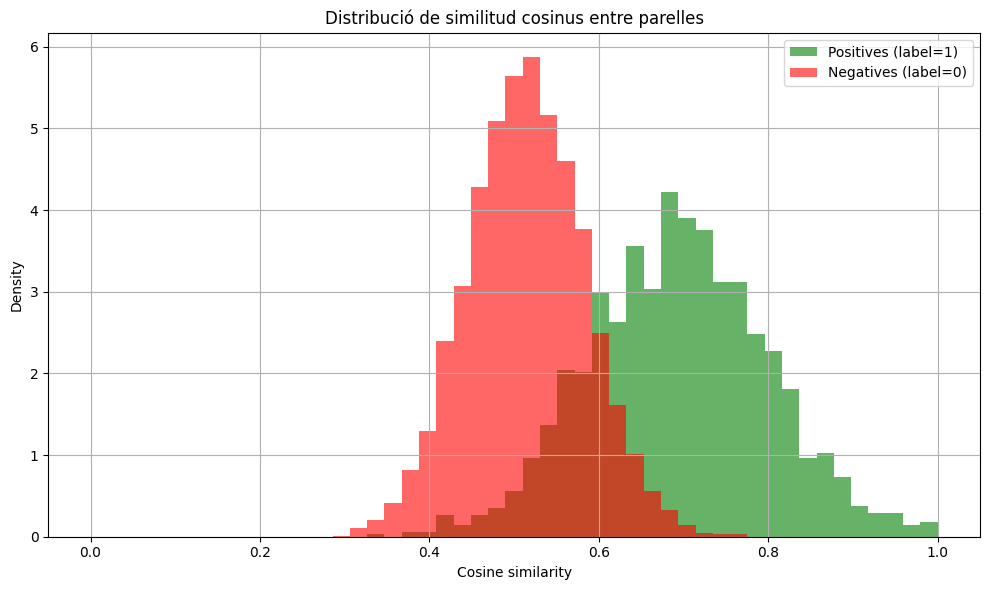

In [2]:
import matplotlib.pyplot as plt

# Dibuixa histograma
sim_positives = [s for s, l in zip(similaritats, etiquetes) if l == 1]
sim_negatives = [s for s, l in zip(similaritats, etiquetes) if l == 0]

plt.figure(figsize=(10, 6))
bins = np.linspace(0, 1, 50)

plt.hist(sim_positives, bins, alpha=0.6, label="Positives (label=1)", color="green", density=True)
plt.hist(sim_negatives, bins, alpha=0.6, label="Negatives (label=0)", color="red", density=True)

plt.xlabel("Cosine similarity")
plt.ylabel("Density")
plt.title("Distribució de similitud cosinus entre parelles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
from sklearn.metrics import f1_score

# Prova diversos llindars
thresholds = np.linspace(0, 1, 100)
f1s = [f1_score(etiquetes, [1 if s >= t else 0 for s in similaritats]) for t in thresholds]

# Troba el millor llindar
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"Millor llindar segons F1-score: {best_threshold:.2f} (F1 = {f1s[best_idx]:.4f})")


Millor llindar segons F1-score: 0.61 (F1 = 0.8054)


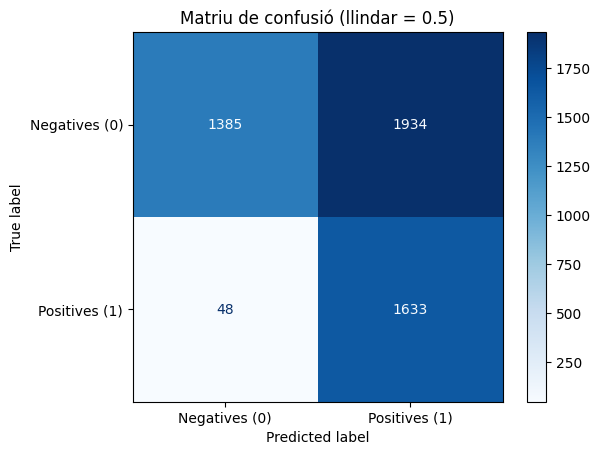

🔢 Valors:
TN (negatives correctes): 1385
FP (falsos positius):     1934
FN (falsos negatius):     48
TP (positives correctes): 1633


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ───────────────────────────────────────────────────
# Tria un llindar per fer classificació binària
llindar = 0.5  # pots ajustar-ho (0.5, 0.75, etc.)

# Generem prediccions: si similitud > llindar → positiva
prediccions = [1 if s >= llindar else 0 for s in similaritats]

# ───────────────────────────────────────────────────
# Matriu de confusió
cm = confusion_matrix(etiquetes, prediccions)
labels = ["Negatives (0)", "Positives (1)"]

# Mostrem matriu
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title(f"Matriu de confusió (llindar = {llindar})")
plt.show()

# També mostrem les xifres
tn, fp, fn, tp = cm.ravel()
print("🔢 Valors:")
print(f"TN (negatives correctes): {tn}")
print(f"FP (falsos positius):     {fp}")
print(f"FN (falsos negatius):     {fn}")
print(f"TP (positives correctes): {tp}")


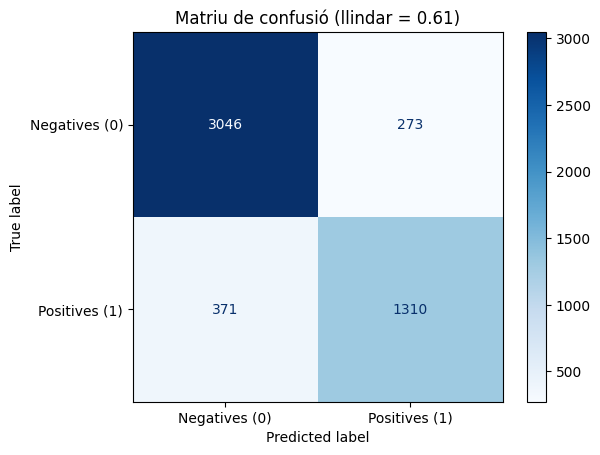

🔢 Valors:
TN (negatives correctes): 3046
FP (falsos positius):     273
FN (falsos negatius):     371
TP (positives correctes): 1310


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ───────────────────────────────────────────────────
# Tria un llindar per fer classificació binària
llindar = 0.61  # pots ajustar-ho (0.5, 0.75, etc.)

# Generem prediccions: si similitud > llindar → positiva
prediccions = [1 if s >= llindar else 0 for s in similaritats]

# ───────────────────────────────────────────────────
# Matriu de confusió
cm = confusion_matrix(etiquetes, prediccions)
labels = ["Negatives (0)", "Positives (1)"]

# Mostrem matriu
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title(f"Matriu de confusió (llindar = {llindar})")
plt.show()

# També mostrem les xifres
tn, fp, fn, tp = cm.ravel()
print("🔢 Valors:")
print(f"TN (negatives correctes): {tn}")
print(f"FP (falsos positius):     {fp}")
print(f"FN (falsos negatius):     {fn}")
print(f"TP (positives correctes): {tp}")


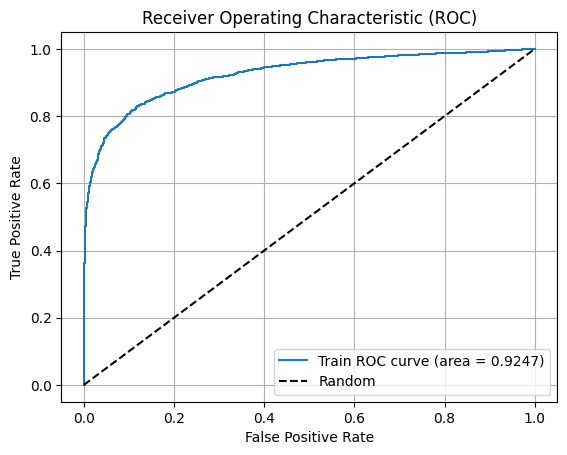

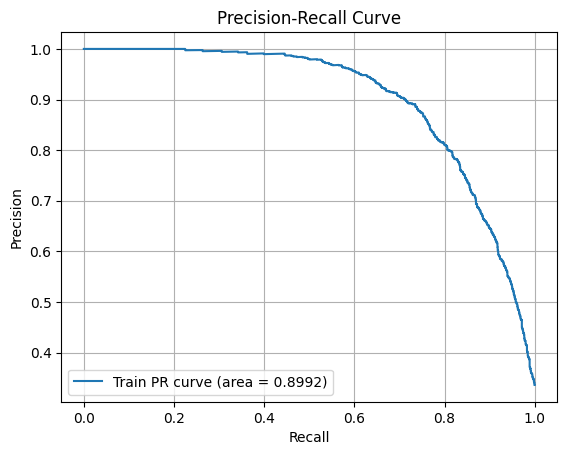

In [5]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(etiquetes, similaritats)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Train ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(etiquetes, similaritats)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"Train PR curve (area = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()
 